## Get Data

In [11]:
import pandas as pd
import pickle

# convert back
data = pd.read_pickle('vars/data.pkl')
with open('vars/avg_dicts.pkl', 'rb') as f:
    avg_dicts = pickle.load(f)
with open('vars/profile_dicts.pkl', 'rb') as f:
    profile_dicts = pickle.load(f)
with open('vars/timing_dicts.pkl', 'rb') as f:
    timing_dicts = pickle.load(f)

In [12]:
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='red')
    plt.setp(bp['caps'][0], color='red')
    plt.setp(bp['caps'][1], color='red')
    plt.setp(bp['whiskers'][0], color='red')
    plt.setp(bp['whiskers'][1], color='red')
    plt.setp(bp['medians'][0], color='red')

    plt.setp(bp['boxes'][1], color='blue')
    plt.setp(bp['caps'][2], color='blue')
    plt.setp(bp['caps'][3], color='blue')
    plt.setp(bp['whiskers'][2], color='blue')
    plt.setp(bp['whiskers'][3], color='blue')
    plt.setp(bp['medians'][1], color='blue')


## General Preprocessing

In [13]:
from sklearn.preprocessing import LabelEncoder

# encode categorical variables
le = LabelEncoder()
data['pressure'] = le.fit_transform(data.pressure)
data['name'] = le.fit_transform(data.name)

In [14]:
# define feature columns
feature_cols = [x for x in data.columns if "bin" in x] + ["avg", "max", "total_time"]

In [15]:
from sklearn.preprocessing import StandardScaler

# columns should have zero mean and unit variance
ss = StandardScaler()
data[feature_cols] = ss.fit_transform(data[feature_cols])

/home/dunntj/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/dunntj/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Classify Swipes for Each User
#### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
% matplotlib inline

BINS_TO_INCLUDE = 10

#names = ["alex", "ben_l", "ben_m", "jenna", "miao", "natasha", "nick", "sean", "yiqun"]
names = ["user"+str(i) for i in range(10)]
for idx, name in enumerate(names):
    USER_SWIPES = data['name'] == idx
    OTHER_SWIPES = data['name'] != idx
    
    feature_cols = ["timebin"+str(i) for i in range(BINS_TO_INCLUDE)] + ["avgbin"+str(i) for i in range(BINS_TO_INCLUDE)] + ["maxbin"+str(i) for i in range(BINS_TO_INCLUDE)] + ["avg", "max", "total_time"]

    X_train = data.loc[OTHER_SWIPES, feature_cols]
    y_train = data.loc[OTHER_SWIPES, 'pressure']

    X_test = data.loc[USER_SWIPES, feature_cols]
    y_test = data.loc[USER_SWIPES, 'pressure']

    rfc = RandomForestClassifier(n_estimators = 500, max_features=6)
    rfc = rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(name+": {0:.2f}% accuracy".format(100*(cm[0,0]+cm[1,1]) / cm.sum()))
    print(cm, "\n")

user0: 79.05% accuracy
[[105  36]
 [ 26 129]] 

user1: 71.79% accuracy
[[128  28]
 [ 60  96]] 

user2: 82.96% accuracy
[[135  21]
 [ 32 123]] 

user3: 85.16% accuracy
[[130  30]
 [ 16 134]] 

user4: 71.20% accuracy
[[103  52]
 [ 37 117]] 

user5: 75.00% accuracy
[[ 82  73]
 [  4 149]] 

user6: 65.70% accuracy
[[ 95  58]
 [ 48 108]] 

user7: 84.47% accuracy
[[131  24]
 [ 24 130]] 

user8: 86.73% accuracy
[[136  18]
 [ 23 132]] 



In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
% matplotlib inline

#names = ["alex", "ben_l", "ben_m", "jenna", "miao", "natasha", "nick", "sean", "yiqun"]
names = ["user"+str(i) for i in range(9)]
accuracy_results = dict()
for name in names:
    accuracy_results[name] = []
    
MAX_SAMPLES = 13
NUM_TESTS = 1

for s in range(MAX_SAMPLES):
    print("s:", s)
    #WEIGHT = int(50/(s+1))
    WEIGHT = 2
    for idx, name in enumerate(names):
        accuracy = 0
        for test_id in range(NUM_TESTS):
            # define constants
            HARD_USER_SWIPES = (data['name'] == idx) & (data['pressure'] == 0)
            SOFT_USER_SWIPES = (data['name'] == idx) & (data['pressure'] == 1)
            OTHER_SWIPES = data['name'] != idx

            # use all data from other users for training
            X_train = data.loc[OTHER_SWIPES, feature_cols]
            y_train = data.loc[OTHER_SWIPES, 'pressure']

            # break this user's data into hard and soft swipes
            X_hard = data.loc[HARD_USER_SWIPES, feature_cols]
            y_hard = data.loc[HARD_USER_SWIPES, 'pressure']
            X_soft = data.loc[SOFT_USER_SWIPES, feature_cols]
            y_soft = data.loc[SOFT_USER_SWIPES, 'pressure']

            # select the appropriate number of each type of swipe from this user
            X_hardtest, X_hardtrain, y_hardtest, y_hardtrain = train_test_split(X_hard, y_hard, test_size=s)
            X_softtest, X_softtrain, y_softtest, y_softtrain = train_test_split(X_soft, y_soft, test_size=s)

            # weight the training swipes from this user (for emphasis)
            X_softtrain = X_softtrain.append([X_softtrain]*WEIGHT, ignore_index=True)
            y_softtrain = y_softtrain.append([y_softtrain]*WEIGHT, ignore_index=True)

            # concatenate into training and testing data sets
            X_train = pd.concat([X_train, X_hardtrain, X_softtrain])
            y_train = y_train.append(y_hardtrain).append(y_softtrain)
            #X_train = pd.concat([X_train, X_hardtrain])
            #y_train = y_train.append(y_hardtrain)
            #X_train = pd.concat([X_train, X_softtrain])
            #y_train = y_train.append(y_softtrain)
            
            X_test = pd.concat([X_hardtest, X_softtest])
            y_test = y_hardtest.append(y_softtest)

            # train classifier and make predictions
            rfc = RandomForestClassifier(n_estimators = 300, max_features=8)
            rfc = rfc.fit(X_train, y_train)
            y_pred = rfc.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            accuracy += (100/NUM_TESTS)*(cm[0,0]+cm[1,1]) / cm.sum()
        accuracy_results[name].append(accuracy)

s: 0


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt # weight = 2, cutoff = 4
for name in names:
    plt.plot(accuracy_results[name])
plt.ylabel("Classifier accuracy", fontsize=12)
plt.xlabel("Number of user's own hard and soft samples included", fontsize=12)
plt.legend(names2, framealpha=0.5, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

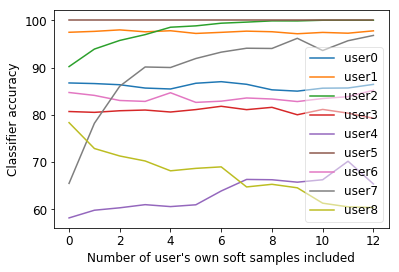

In [27]:
import matplotlib.pyplot as plt # weight = 2, cutoff = 4
for name in names:
    plt.plot(accuracy_results[name])
plt.ylabel("Classifier accuracy", fontsize=12)
plt.xlabel("Number of user's own soft samples included", fontsize=12)
plt.legend(names, framealpha=0.5, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

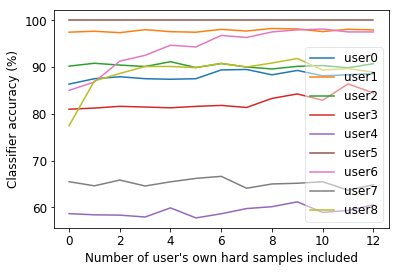

In [25]:
import matplotlib.pyplot as plt # weight = 2, cutoff = 4
for name in names:
    plt.plot(accuracy_results[name])
plt.ylabel("Classifier accuracy (%)", fontsize=12)
plt.xlabel("Number of user's own hard samples included", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(names, framealpha=0.5, fontsize=12)
plt.show()

## Per-user Before/Middle/After Confusion Matrices

s: 0
accuracy: 82.23%
s: 6
accuracy: 89.14%
s: 13
accuracy: 90.99%


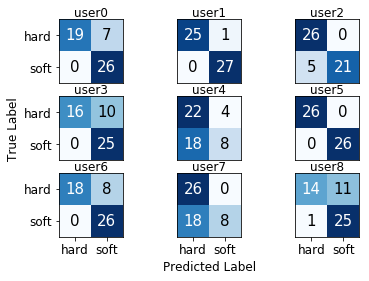

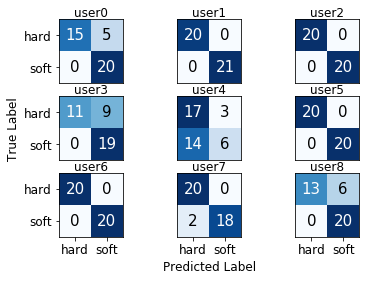

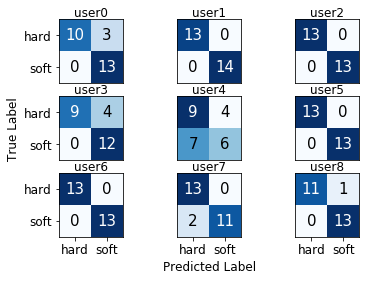

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
% matplotlib inline

names = ["user"+str(i) for i in range(9)]
accuracy_results = dict()
for name in names:
    accuracy_results[name] = []
    
MAX_SAMPLES = 13
NUM_TESTS = 1

for s in [0, int(MAX_SAMPLES/2), MAX_SAMPLES]:
    print("s:", s)
    WEIGHT = 2
    cms = np.ndarray(shape=(9,2,2)).astype(int)

    for idx, name in enumerate(names):
        accuracy = 0
        # define constants
        HARD_USER_SWIPES = (data['name'] == idx) & (data['pressure'] == 0)
        SOFT_USER_SWIPES = (data['name'] == idx) & (data['pressure'] == 1)
        OTHER_SWIPES = data['name'] != idx

        # use all data from other users for training
        X_train = data.loc[OTHER_SWIPES, feature_cols]
        y_train = data.loc[OTHER_SWIPES, 'pressure']

        # break this user's data into hard and soft swipes
        X_hard = data.loc[HARD_USER_SWIPES, feature_cols]
        y_hard = data.loc[HARD_USER_SWIPES, 'pressure']
        X_soft = data.loc[SOFT_USER_SWIPES, feature_cols]
        y_soft = data.loc[SOFT_USER_SWIPES, 'pressure']

        # select the appropriate number of each type of swipe from this user
        X_hardtest, X_hardtrain, y_hardtest, y_hardtrain = train_test_split(X_hard, y_hard, test_size=s, random_state=3)
        X_softtest, X_softtrain, y_softtest, y_softtrain = train_test_split(X_soft, y_soft, test_size=s, random_state=3)

        # weight the training swipes from this user (for emphasis)
        X_softtrain = X_softtrain.append([X_softtrain]*WEIGHT, ignore_index=True)
        y_softtrain = y_softtrain.append([y_softtrain]*WEIGHT, ignore_index=True)

        # concatenate into training and testing data sets
        X_train = pd.concat([X_train, X_hardtrain, X_softtrain])
        y_train = y_train.append(y_hardtrain).append(y_softtrain)

        X_test = pd.concat([X_hardtest, X_softtest])
        y_test = y_hardtest.append(y_softtest)

        # train classifier and make predictions
        rfc = RandomForestClassifier(n_estimators = 300, max_features=8)
        rfc = rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)

        # calculate per-user confusion matrices
        for i in range(len(y_pred)):
            if y_test.tolist()[i] == 0:
                if y_pred[i] == 0:
                    cms[idx][0][0] += 1
                else:
                    cms[idx][0][1] += 1
            else: # y_pred == 1
                if y_pred[i] == 0:
                    cms[idx][1][0] += 1
                else:
                    cms[idx][1][1] += 1

    # plot the per-user confusion matrix
    fig = figure()
    for row in range(3):
        for col in range(3):
            idx = row*3 + col
            ax = fig.add_subplot(3,3,idx+1)

            cax = ax.matshow(cms[idx], interpolation='nearest', cmap="Blues")

            for i, j in itertools.product(range(2), range(2)):
                plt.text(j, i, format(cms[idx][i, j], 'd'),
                     horizontalalignment="center",
                     verticalalignment='center',
                     fontsize=15,
                     color="white" if cms[idx][i, j] > cms.max()/2 else "black")

            tick_marks = np.arange(2)
            no_tick_marks = []
            pressures = ['hard', 'soft']
            if row == 2:
                plt.xticks(tick_marks, pressures, fontsize=12)
            else:
                plt.xticks(no_tick_marks);
            if col == 0:
                plt.yticks(tick_marks, pressures, fontsize=12)
            else:
                plt.yticks(no_tick_marks);
            ax.xaxis.set_ticks_position('bottom')


            #plt.tight_layout()
            ttl = plt.title("user"+str(idx))
            ttl.set_position([0.5, .95])

            if row == 2 and col == 1:
                plt.xlabel('Predicted Label', fontsize=12);
            if row == 1 and col == 0:
                plt.ylabel('True Label', fontsize=12);        

    correct = 0
    for i in range(9):
        correct += cms[i][0][0] + cms[i][1][1]
    print("accuracy: {0:.2f}%".format(100*correct / cms.sum()))

## N% BINS RESULTS

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
% matplotlib inline

BINS_TO_INCLUDE = 10

#names = ["alex", "ben_l", "ben_m", "jenna", "miao", "natasha", "nick", "sean", "yiqun"]
names = ["user"+str(i) for i in range(9)]
for idx, name in enumerate(names):
    USER_SWIPES = data['name'] == idx
    OTHER_SWIPES = data['name'] != idx
    
    feature_cols = ["timebin"+str(i) for i in range(BINS_TO_INCLUDE)] + ["avgbin"+str(i) for i in range(BINS_TO_INCLUDE)] + ["maxbin"+str(i) for i in range(BINS_TO_INCLUDE)] + ["avg", "max", "total_time"]

    X_train = data.loc[OTHER_SWIPES, feature_cols]
    y_train = data.loc[OTHER_SWIPES, 'pressure']

    X_test = data.loc[USER_SWIPES, feature_cols]
    y_test = data.loc[USER_SWIPES, 'pressure']

    rfc = RandomForestClassifier(n_estimators = 500, max_features=6)
    rfc = rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(name+": {0:.2f}% accuracy".format(100*(cm[0,0]+cm[1,1]) / cm.sum()))
    print(cm, "\n")